## Caravan customer identification study

- Author: Tommy Lam
- Date: 22 Apr, 2019
- Programming language: R
- Data Source: The CoIL Challenge 2000 http://liacs.leidenuniv.nl/~puttenpwhvander/library/cc2000/
- Abstract: This study targets the caravcan customer identification. The study begins with data exploration and followed by model analysis to predict the potential customers.

### Libraries required:

In [1]:
library(tidyverse)
library(plyr)
library(dplyr)
library("Hmisc")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.1.1     ✔ purrr   0.3.3
✔ tibble  2.1.1     ✔ dplyr   0.8.4
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from ‘package:purrr’:

    compact


Loading required package: lattice


## Data Importing

First of all, the training data would be imported in order to build a model based on training data.

1. TICDATA2000.txt: Dataset to train and validate prediction models and build a description (5822 customer records). Each record consists of 86 attributes, containing sociodemographic data (attribute 1-43) and product ownership (attributes 44-86).The sociodemographic data is derived from zip codes. All customers living in areas with the same zip code have the same sociodemographic attributes. Attribute 86, "CARAVAN:Number of mobile home policies", is the target variable.
2. TICEVAL2000.txt: Dataset for predictions (4000 customer records). It has the same format as TICDATA2000.txt, only the target is missing. Participants are supposed to return the list of predicted targets only. All datasets are in tab delimited format. The meaning of the attributes and attribute values is given below.
3. TICTGTS2000.txt Targets for the evaluation set.

Data dictionary: https://kdd.ics.uci.edu/databases/tic/dictionary.txt

In [5]:
train_data = read.csv('data/ticdata2000.txt',sep = '',header = F)
predict_data = read.csv('data/TICEVAL2000.txt',sep = '',header = F)
target_data = read.csv('data/TICTGTS2000.txt',sep = '',header = F)

head(train_data,3)
head(predict_data,3)
head(target_data,3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,33,1,3,2,8,0,5,1,3,7,⋯,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,1,4,1,4,6,⋯,0,0,0,1,0,0,0,0,0,0
3,37,1,2,2,8,0,4,2,4,3,⋯,0,0,0,1,0,0,0,0,0,0


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,33,1,4,2,8,0,6,0,3,5,⋯,0,0,0,0,1,0,0,0,0,0
2,6,1,3,2,2,0,5,0,4,5,⋯,2,0,0,0,1,0,0,0,0,0
3,39,1,3,3,9,1,4,2,3,5,⋯,1,0,0,0,1,0,0,0,0,0


,V1
,<int>
1,0
2,1
3,0


## Data Wrangling

Some of the data are represented by coding, for example, the age-group is presented as 1 to 6. Since these variables are continuous and would be useful to build the models, they are converted into mean values for each group.

In [6]:
# age
age = data.frame('V4' = c(1,2,3,4,5,6), 'age' = c(25,35,45,55,65,75))
# MGODRK Roman catholic 
L3 = data.frame('V6' = c(0,1,2,3,4,5,6,7,8,9), 'L3' = c(0,5.5,17,30,43,56,69,82,94,100))
# Income
L4 = data.frame('V42' = c(0,1,2,3,4,5,6,7,8,9), 'L4' = c(0,25,74.5,149.5,349.5,749.5,2999.5,7499.5,14999.5,20000))


A function is built for converting the coding data, and update the training data accordingly.

In [7]:
update_value = function(data,data_name,column, update) {
    temp = data[column] %>% join(update)
    data[column] = temp[names(update)[2]]
    assign(data_name,data,envir=.GlobalEnv)
}

In [8]:
# update the training data
update_value(train_data,'train_data','V4',age)
update_value(train_data,'train_data','V6',L3)
update_value(train_data,'train_data','V42',L4)

# update the target data
update_value(predict_data,'predict_data','V4',age)
update_value(predict_data,'predict_data','V6',L3)
update_value(predict_data,'predict_data','V42',L4)



Joining by: V4

Joining by: V6

Joining by: V42

Joining by: V4

Joining by: V6

Joining by: V42



In [9]:
head(train_data,3)
head(predict_data,3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86
,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,33,1,3,35,8,0.0,5,1,3,7,⋯,0,0,0,1,0,0,0,0,0,0
2,37,1,2,35,8,5.5,4,1,4,6,⋯,0,0,0,1,0,0,0,0,0,0
3,37,1,2,35,8,0.0,4,2,4,3,⋯,0,0,0,1,0,0,0,0,0,0


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85
,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,33,1,4,35,8,0.0,6,0,3,5,⋯,0,0,0,0,1,0,0,0,0,0
2,6,1,3,35,2,0.0,5,0,4,5,⋯,2,0,0,0,1,0,0,0,0,0
3,39,1,3,45,9,5.5,4,2,3,5,⋯,1,0,0,0,1,0,0,0,0,0


So now the data can ready for further analysis.

## Data Exploration and Visualisation

In [31]:
# colnames(target_data) = 'V86'
# explore = cbind(predict_data,target_data)
explore = train_data
head(explore,3)
explore$V86 = as.character(explore$V86)
# explore$V5 = as.character(explore$V5)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86
,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,33,1,3,35,8,0.0,5,1,3,7,⋯,0,0,0,1,0,0,0,0,0,0
2,37,1,2,35,8,5.5,4,1,4,6,⋯,0,0,0,1,0,0,0,0,0,0
3,37,1,2,35,8,0.0,4,2,4,3,⋯,0,0,0,1,0,0,0,0,0,0


### Age distribution
- 40-50 is the largest group, and followed by 30-40 and 50-60

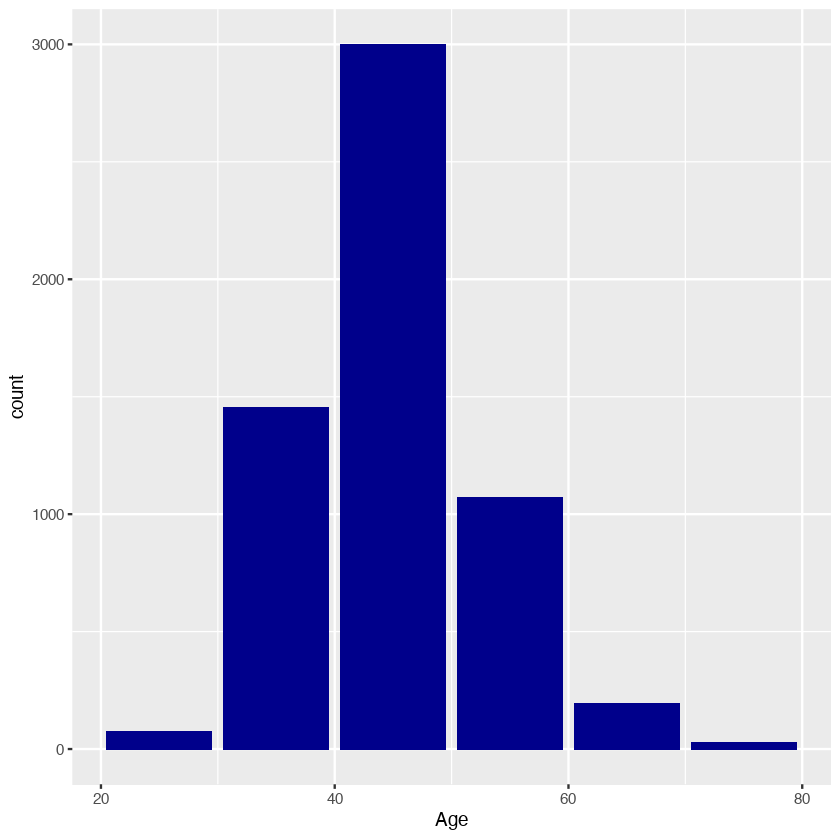

In [32]:
g=ggplot(data = explore)
g + 
geom_bar(aes(x = V4),position = 'dodge', fill= 'dark blue') + 
xlab('Age')

### Age split among caravan users and non-users
The following graph shows the age distribution split by caravan customers. 

0: non-caravan customers, 1: caravan customers

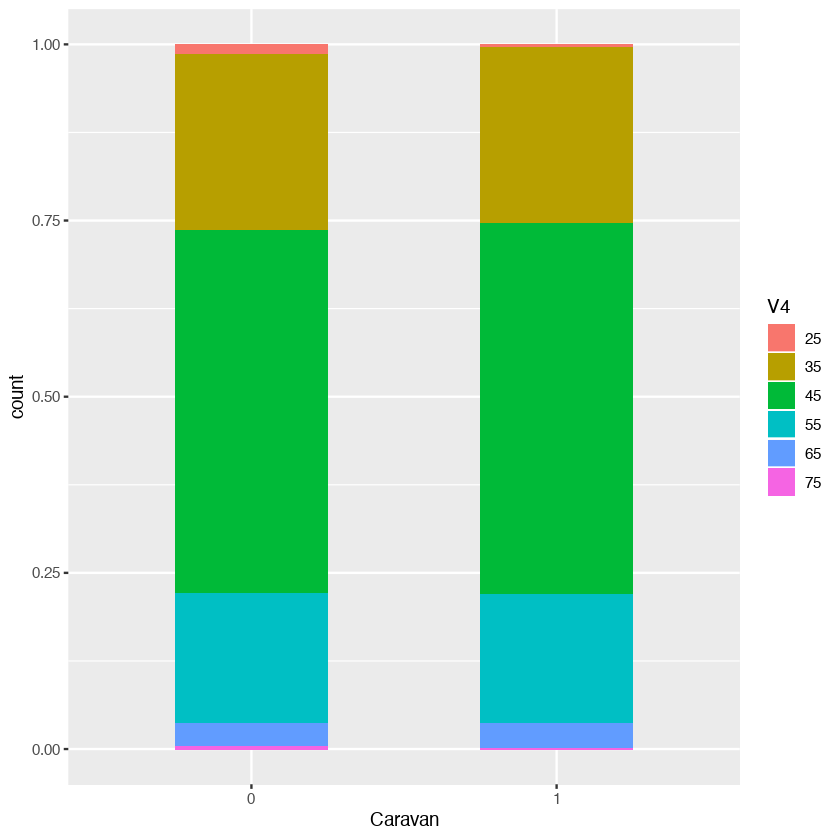

In [86]:
explore$V4 = as.character(explore$V4)
ggplot(data =  explore) + 
geom_bar(aes(x = V86,fill = V4),position = 'fill',width = 0.5) + 
xlab('Caravan') 

From the graph, we can see that caravan customers are generally younger the non-caravan customers, while the upper 3 stacked bar representing age from 20 to 50.

In [89]:
means <- aggregate(V3 ~  V86, explore, mean)
means

V86,V3
<chr>,<dbl>
0,2.671721
1,2.790230


### Average Income

The graph below shows the distribution of average income between caravan users or non-users. Caravan users generally have higher income than non-user.

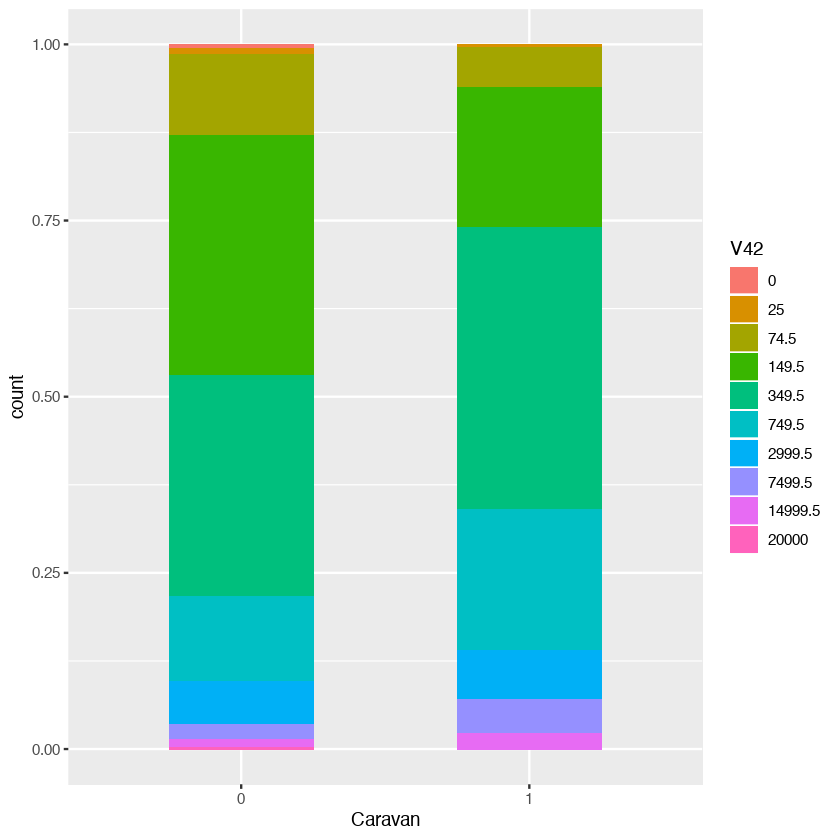

In [23]:
explore$V42 = as.character(explore$V42)
explore$V42 <- factor(explore$V42, levels = c('0','25','74.5','149.5','349.5','749.5','2999.5','7499.5','14999.5','20000'))
ggplot(data = explore ) + geom_bar(aes(x = V86,fill = V42),position = 'fill',width = 0.5) + xlab('Caravan') 

### Average Household Size

In [96]:
paste('Carvan customer:',round(mean(as.numeric(explore[explore$V83 == 1,]$V3)),2))
paste('Non-Carvan customer:',round(mean(as.numeric(explore[explore$V83 == 0,]$V3)),2))

[1] "Carvan customer: 2.82"

[1] "Non-Carvan customer: 2.67"

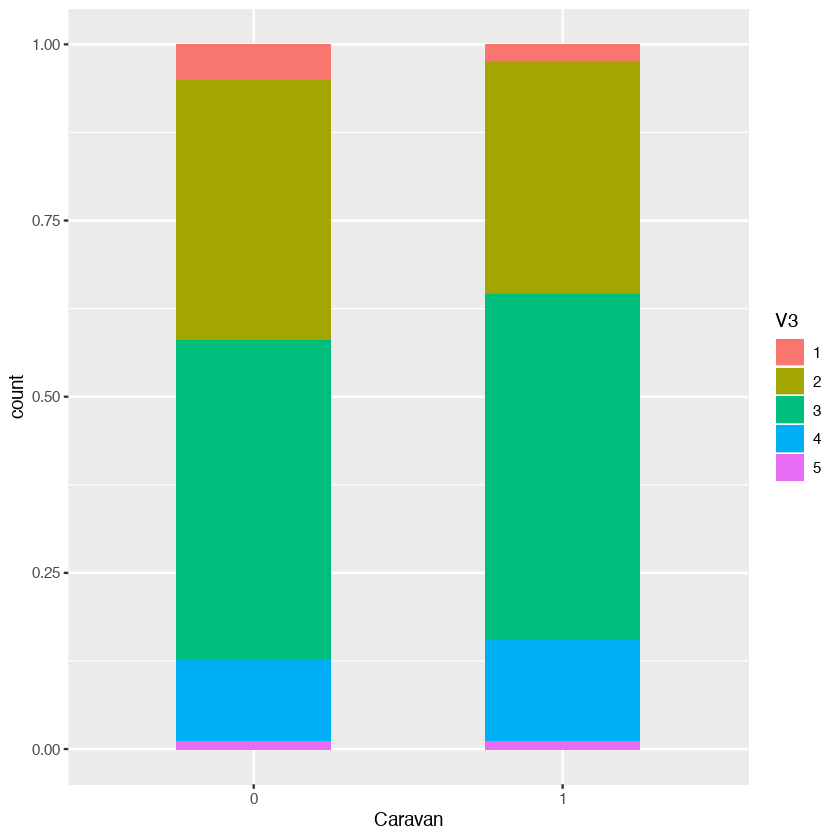

In [25]:
explore$V3 = as.character(explore$V3)
ggplot(data = explore ) + geom_bar(aes(x = V86,fill = V3),position = 'fill',width = 0.5) + xlab('Caravan') 

This graph shows the caravan customers tend to have a larger household size.

Now, we will focus on the caravan user. 

In [26]:
# only caravan customer are recorded
caravan = explore[explore$V86==1,]

### Customer main type
 
The following graph shows the constitution of each customer type:

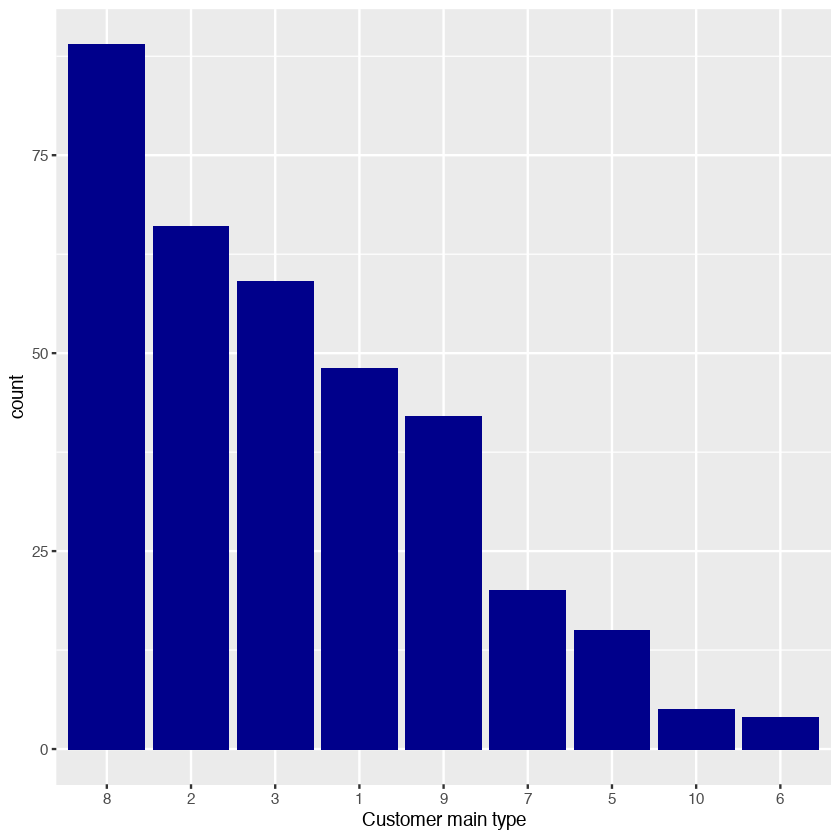

In [95]:
caravan$V5 = as.character(caravan$V5)
ggplot(data=caravan)+
geom_bar(aes(forcats::fct_infreq(V5)), fill ='dark blue') + 
xlab('Customer main type')

The major customer type is 'Family with grown ups'. Second and third are 'Driven Growers' and 'Average Family' respectively.

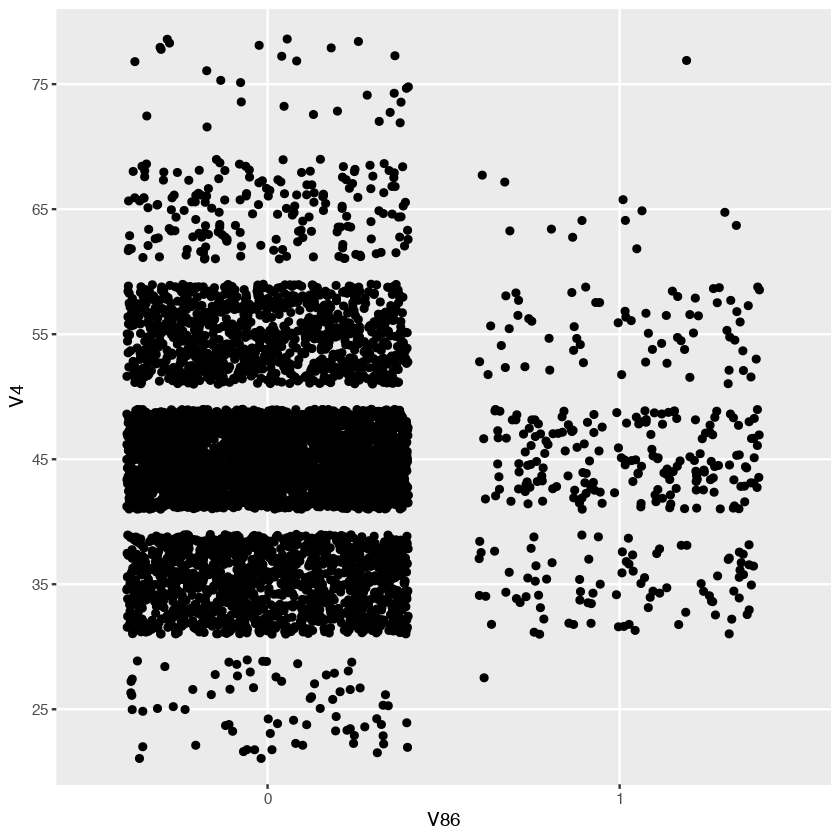

In [103]:
ggplot(data = explore) +
geom_jitter(aes(x = V86 , y = V4))

From the jitter plot above, we may also find that most caravan using are fall within age range of 30 - 50.

### Correlation
In this section, we will explore the correlation of caravan against the rest of the variables, so as to discover some important factors that drive customers to use caravan insurance.

In [28]:
## Generating the correlation matrix
res2 = rcorr(as.matrix(explore))
corr = as.data.frame(res2$r[86,])
colnames(corr) = 'corr'
corr$abs = abs(corr$corr)

The table following shows the top correlated variables against caravan insurance user

In [29]:
corr[order(corr$abs,decreasing = T),][2:10,]

,corr,abs
,<dbl>,<dbl>
V47,0.15090971,0.15090971
V68,0.14421046,0.14421046
V82,0.10569950,0.10569950
V44,0.09646269,0.09646269
V43,0.09593826,0.09593826
V59,0.09444599,0.09444599
V61,0.09136116,0.09136116
V18,-0.09056133,0.09056133
V65,0.08938747,0.08938747


V47 (Contribution car policies), V43 (Purchasing power class), V44 (Contribution private third party insurance) and V68 (Number of car policies) are the top correlated variables.

We can understand customers related to car policies show strong relation to caravan usage. Also, those with higher contribution to private thrid party insurance are also more related to caravan usage.

## Data Modelling

### 1. Linear regression model

In [10]:
model_lm = lm(V86~.,data = train_data)

In [11]:
summary(model_lm)


Call:
lm(formula = V86 ~ ., data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.67195 -0.08688 -0.04634 -0.00606  1.04632 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.714e-01  4.303e-01   1.793 0.073068 .  
V1           3.573e-03  2.251e-03   1.587 0.112476    
V2          -7.216e-03  7.673e-03  -0.940 0.347059    
V3          -1.305e-03  7.175e-03  -0.182 0.855671    
V4           1.111e-03  4.956e-04   2.242 0.025021 *  
V5          -1.577e-02  1.010e-02  -1.562 0.118459    
V6          -1.027e-03  6.055e-04  -1.696 0.089882 .  
V7          -4.743e-03  6.588e-03  -0.720 0.471633    
V8          -3.314e-03  5.911e-03  -0.561 0.575060    
V9          -7.197e-03  6.323e-03  -1.138 0.255074    
V10          8.618e-03  7.483e-03   1.152 0.249504    
V11          2.005e-03  7.140e-03   0.281 0.778902    
V12          5.671e-03  7.555e-03   0.751 0.452927    
V13         -3.780e-03  6.542e-03  -0.578 0.563410    
V14     

In linear regression prediction, in order to search for 800 potential customers, those with 800 highest predicted value will be categorised as potential customers.

In [12]:
lm.probs <- predict(model_lm, 
                    newdata = predict_data, 
                    type = "response")
## top 800 predicted value will be assigned 1 in V86
lm.pred <- ifelse(lm.probs > sort(lm.probs,decreasing = T)[801], 1, 0)


In [13]:
predicted_result_lm = as.data.frame(lm.pred)

In [14]:
## comparing with the given target data with the predicted result
compare = cbind(target_data,predicted_result_lm)
check = compare %>% filter(V1 == 1)
sum(check[,2])/sum(check[,1])

[1] 0.5042017

Summary for linear regression (full):

- Residual standard error: 0.23
- Adjusted R-squared:  0.05914 
- Prediction accuracy: 50.4%

### Stepwise linear regression:
Aparting from linear regression, stepwise regression will also be performed.

In [15]:
model_lm_step = step(model_lm)
summary(model_lm_step)

Start:  AIC=-17029.14
V86 ~ V1 + V2 + V3 + V4 + V5 + V6 + V7 + V8 + V9 + V10 + V11 + 
    V12 + V13 + V14 + V15 + V16 + V17 + V18 + V19 + V20 + V21 + 
    V22 + V23 + V24 + V25 + V26 + V27 + V28 + V29 + V30 + V31 + 
    V32 + V33 + V34 + V35 + V36 + V37 + V38 + V39 + V40 + V41 + 
    V42 + V43 + V44 + V45 + V46 + V47 + V48 + V49 + V50 + V51 + 
    V52 + V53 + V54 + V55 + V56 + V57 + V58 + V59 + V60 + V61 + 
    V62 + V63 + V64 + V65 + V66 + V67 + V68 + V69 + V70 + V71 + 
    V72 + V73 + V74 + V75 + V76 + V77 + V78 + V79 + V80 + V81 + 
    V82 + V83 + V84 + V85

       Df Sum of Sq    RSS    AIC
- V74   1   0.00002 303.35 -17031
- V68   1   0.00015 303.35 -17031
- V42   1   0.00035 303.35 -17031
- V48   1   0.00057 303.35 -17031
- V20   1   0.00088 303.35 -17031
- V67   1   0.00134 303.35 -17031
- V53   1   0.00138 303.35 -17031
- V29   1   0.00151 303.35 -17031
- V3    1   0.00175 303.35 -17031
- V27   1   0.00187 303.35 -17031
- V23   1   0.00228 303.35 -17031
- V62   1   0.00285 303.


Call:
lm(formula = V86 ~ V1 + V4 + V5 + V6 + V10 + V17 + V18 + V21 + 
    V22 + V28 + V30 + V35 + V36 + V40 + V41 + V43 + V44 + V46 + 
    V47 + V55 + V57 + V58 + V59 + V63 + V76 + V78 + V79 + V80 + 
    V82 + V83 + V84 + V85, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.61857 -0.08629 -0.04685 -0.00782  1.04151 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.5758574  0.3568128   1.614  0.10661    
V1           0.0034226  0.0021958   1.559  0.11912    
V4           0.0010426  0.0004068   2.563  0.01041 *  
V5          -0.0148184  0.0098216  -1.509  0.13141    
V6          -0.0006370  0.0003224  -1.976  0.04822 *  
V10          0.0053086  0.0018547   2.862  0.00422 ** 
V17         -0.0069172  0.0029185  -2.370  0.01782 *  
V18         -0.0130170  0.0029932  -4.349 1.39e-05 ***
V21         -0.0064605  0.0034437  -1.876  0.06070 .  
V22          0.0032071  0.0018885   1.698  0.08952 .  
V28          0.0032702  0.002

In [16]:
lm.probs <- predict(model_lm_step, 
                    newdata = predict_data, 
                    type = "response")
lm.pred <- ifelse(lm.probs > sort(lm.probs,decreasing = T)[801], 1, 0)

In [17]:
predicted_result_lm = as.data.frame(lm.pred)

In [18]:
## comparing with the given target data with the predicted result
compare = cbind(target_data,predicted_result_lm)
check = compare %>% filter(V1 == 1)
sum(check[,2])/sum(check[,1])

[1] 0.4789916

Summary for linear regression (stepwise selection):
- Residual standard error: 0.2294
- Adjusted R-squared: 0.06363
- Prediction accuracy: 47.9%

### 2. Logistic regression

By checking on the unique values in V86, there are either 0 or 1.
Therefore, logistic regression is also suggested:

In [19]:
unique(train_data[,86])

[1] 0 1

In [20]:
model_log = glm(formula = V86~.,data = train_data)
summary(model_log)


Call:
glm(formula = V86 ~ ., data = train_data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.67195  -0.08688  -0.04634  -0.00606   1.04632  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.714e-01  4.303e-01   1.793 0.073068 .  
V1           3.573e-03  2.251e-03   1.587 0.112476    
V2          -7.216e-03  7.673e-03  -0.940 0.347059    
V3          -1.305e-03  7.175e-03  -0.182 0.855671    
V4           1.111e-03  4.956e-04   2.242 0.025021 *  
V5          -1.577e-02  1.010e-02  -1.562 0.118459    
V6          -1.027e-03  6.055e-04  -1.696 0.089882 .  
V7          -4.743e-03  6.588e-03  -0.720 0.471633    
V8          -3.314e-03  5.911e-03  -0.561 0.575060    
V9          -7.197e-03  6.323e-03  -1.138 0.255074    
V10          8.618e-03  7.483e-03   1.152 0.249504    
V11          2.005e-03  7.140e-03   0.281 0.778902    
V12          5.671e-03  7.555e-03   0.751 0.452927    
V13         -3.780e-03  6.542e-03  -0.578 

In [21]:
glm.probs <- predict(model_log, 
                    newdata = predict_data, 
                    type = "response")

glm.pred <- ifelse(glm.probs > sort(glm.probs,decreasing = T)[801], 1, 0)

In [22]:
predicted_result_log = as.data.frame(glm.pred)

In [23]:
## comparing with the given target data with the predicted result
compare = cbind(target_data,predicted_result_log)
check = compare %>% filter(V1 == 1)
sum(check[,2])/sum(check[,1])

[1] 0.5042017

Summary:

Prediction accuracy: 50.4%

#### Stepwise Logistic regression

In [25]:
model_log_step = step(model_log)
summary(model_log_step)

Start:  AIC=-505.02
V86 ~ V1 + V2 + V3 + V4 + V5 + V6 + V7 + V8 + V9 + V10 + V11 + 
    V12 + V13 + V14 + V15 + V16 + V17 + V18 + V19 + V20 + V21 + 
    V22 + V23 + V24 + V25 + V26 + V27 + V28 + V29 + V30 + V31 + 
    V32 + V33 + V34 + V35 + V36 + V37 + V38 + V39 + V40 + V41 + 
    V42 + V43 + V44 + V45 + V46 + V47 + V48 + V49 + V50 + V51 + 
    V52 + V53 + V54 + V55 + V56 + V57 + V58 + V59 + V60 + V61 + 
    V62 + V63 + V64 + V65 + V66 + V67 + V68 + V69 + V70 + V71 + 
    V72 + V73 + V74 + V75 + V76 + V77 + V78 + V79 + V80 + V81 + 
    V82 + V83 + V84 + V85

       Df Deviance     AIC
- V74   1   303.35 -507.02
- V68   1   303.35 -507.02
- V42   1   303.35 -507.01
- V48   1   303.35 -507.01
- V20   1   303.35 -507.00
- V67   1   303.35 -506.99
- V53   1   303.35 -506.99
- V29   1   303.35 -506.99
- V3    1   303.35 -506.99
- V27   1   303.35 -506.98
- V23   1   303.35 -506.98
- V62   1   303.35 -506.96
- V25   1   303.36 -506.96
- V11   1   303.36 -506.94
- V56   1   303.36 -506.93
- 


Call:
glm(formula = V86 ~ V1 + V4 + V5 + V6 + V10 + V17 + V18 + V21 + 
    V22 + V28 + V30 + V35 + V36 + V40 + V41 + V43 + V44 + V46 + 
    V47 + V55 + V57 + V58 + V59 + V63 + V76 + V78 + V79 + V80 + 
    V82 + V83 + V84 + V85, data = train_data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.61857  -0.08629  -0.04685  -0.00782   1.04151  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.5758574  0.3568128   1.614  0.10661    
V1           0.0034226  0.0021958   1.559  0.11912    
V4           0.0010426  0.0004068   2.563  0.01041 *  
V5          -0.0148184  0.0098216  -1.509  0.13141    
V6          -0.0006370  0.0003224  -1.976  0.04822 *  
V10          0.0053086  0.0018547   2.862  0.00422 ** 
V17         -0.0069172  0.0029185  -2.370  0.01782 *  
V18         -0.0130170  0.0029932  -4.349 1.39e-05 ***
V21         -0.0064605  0.0034437  -1.876  0.06070 .  
V22          0.0032071  0.0018885   1.698  0.08952 .  
V28     

In [26]:
glm_step.probs <- predict(model_log_step, 
                    newdata = predict_data, 
                    type = "response")

glm_step.pred <- ifelse(glm_step.probs > sort(glm_step.probs,decreasing = T)[801], 1, 0)

In [27]:
predicted_result = as.data.frame(glm.pred)

In [28]:
## comparing with the given target data with the predicted result
compare = cbind(target_data,predicted_result)
check = compare %>% filter(V1 == 1)
sum(check[,2])/sum(check[,1])

[1] 0.5042017

Summary:

Prediction accuracy: 47.9%

### Summary

In [29]:
model_summary = data.frame(c('Linear regression (full)','Linear regression (stepwise)','Logistic regression (full)','Logistic regression (stepwise)'),c(50.4,47.9,50.4,47.9))
colnames(model_summary) = c('model', 'accuracy(%)')
model_summary

model,accuracy(%)
Linear regression (full),50.4
Linear regression (stepwise),47.9
Logistic regression (full),50.4
Logistic regression (stepwise),47.9


In conclusion, both linear and logistic regression show a decent prediction of potential customers. 

Since in these models we are choosing 800 potential customers with highest predicted values, we may find that both linear regression and logistic regression show similar result.

However, in reality, there are unknown potential customers. Logistic regression is suggested to use as the output are ranging from 0 to 1 only, which are suitable for us to define potential customers (0 or 1).

For linear regression, it is more suitable to predict continuous values since they might have different ranges of predict values.

### Conclusion
The customers of caravan tend to be younger, higher income and with higher size of household. They would be the target group to be foucused in the future marketing plannig.

Also, according to the correlation analysis, we should pay more attention to customers with stronger contribution to car policies, since they have higher chances to have a caravan insurance.